In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgbm
import pickle

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

Загрузим и объединим обучающую и тестовую выборки для предобработки. У нас нет признаков, которые считаются, задействуя весь датафрейм, поэтому такое объединение не вызовет утечки данных. Но это позволит корректно создать лаговые признаки для тестовой выборки

In [ ]:
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')
df = pd.concat([train_df, test_df])[['date', 'time', 'target', 'temp_pred', 'weather_pred', 'temp']]
df['date'] = pd.to_datetime(df['date']).dt.normalize()

#get test dates for future model fitting
start_test = test_df['date'].min()
end_test = test_df['date'].max()

df.head()

,date,time,target,temp_pred,weather_pred,temp
0,2019-01-01,0,481.510,2.0,"пасм, ветер",2.9
1,2019-01-01,1,462.872,2.0,"пасм, ветер",2.9
2,2019-01-01,2,449.718,2.0,"пасм, ветер",2.9
3,2019-01-01,3,430.908,2.0,"пасм, ветер",4.3
4,2019-01-01,4,415.163,2.0,"пасм, ветер",4.3


Добавим в полученный датафрейм отобранные нами признаки. Функции, перечисленные ниже добавляют только те признаки, которые оказались полезными, т.е. улучшали метрику в ходе наших экспериментов

In [ ]:
def add_calendar_features(df):
    """
    Функция извлекает из даты и добавляет в датафрейм календарные фичи: день (число),
    день недели, номер недели, месяц, год
    """
    df['date'] = pd.to_datetime(df['date']).dt.normalize()
    df['dow'] = df['date'].dt.dayofweek
    df['day'] = df['date'].dt.day
    df['week'] = df['date'].dt.isocalendar().week.astype('int32')
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    return df

In [ ]:
def add_lags(df):
    """
    Функция добавляет избранные лаги для целевой переменной и температуры
    """
    #add target lags
    for i in [24, 24*2, 24*21, 24*4, 24*5, 24*3, 25, 47, 26]:
        df[f'target_lag_{i}'] = df['target'].shift(i)

    #add a temperature lag
    df['temp_lag_3'] = df['temp'].shift(24*3)

    #delete nans where there's no lag data (start of period)
    df['na_sum'] = df.isna().sum(axis=1)
    df = df[df['na_sum'] == 0]
    df = df.drop('na_sum', axis=1)

    #drop actual temperature as it causes dataleaks
    df = df.drop('temp', axis=1)

    return df

In [ ]:
def add_weather_and_daylight(df):
    """
    Функция обрабатывает данные о природном освещении и погоде, создавая в итоге бинарный
    признак, помечающий часы, когда должно быть светло, потому что солнце над горизонтом,
    но темно из-за погодных условий. Мы используем прогнозную погоду во избежание утечек
    """
    #create columns for certain bad weather types
    bad_weathers = {'пасм': 'overcast', 'дожд': 'rain', 'снег': 'snow',
                    'ливень': 'heavy_rain', 'гроз': 'thunder', 'шторм': 'storm'}
    for weather_type in bad_weathers:
        df[bad_weathers[weather_type]] = np.where(df['weather_pred'].str.contains(weather_type), 1, 0)

    #process cloudy separately so that not to include 'малообл'
    df['cloudy'] = np.where((df['weather_pred'].str.contains(' обл')) |
                            (df['weather_pred'].str.startswith('обл')), 1, 0)

    #read and preprocess our table with sunset and sunrise times for each day
    daylight = pd.read_csv('light_day.csv')
    daylight = daylight.rename(columns={'Дата': 'date', 'Восход': 'sunrise', 'Заход': 'sunset'})
    daylight = daylight[['date', 'sunrise', 'sunset']]
    daylight['date'] = pd.to_datetime(daylight['date']).dt.normalize()
    daylight['day'] = daylight['date'].dt.day
    daylight['month'] = daylight['date'].dt.month
    daylight['sunrise'] = daylight['sunrise'].str.replace(':', '.').str.lstrip('0').astype('float')
    daylight['sunset'] = daylight['sunset'].str.replace(':', '.').str.lstrip('0').astype('float')
    daylight = daylight[['day', 'month', 'sunrise', 'sunset']]

    #merge sunset and sunrise data to original df
    df_with_daylight = df.merge(daylight, on=['month', 'day'], how='left')

    #mark light hours, i.e. those between sunrise and sunset
    df_with_daylight['light'] = np.where(df_with_daylight['time'].between(df_with_daylight['sunrise'],
                                                                    df_with_daylight['sunset']), 1, 0)

    #mark hours that should be light but are dark because of bad weather conditions
    df_with_daylight['dark_weather'] = np.where((df_with_daylight['light'] == 1) &
                                  (df_with_daylight[['rain', 'heavy_rain', 'thunder',
                                                  'storm', 'snow', 'overcast', 'cloudy']].any(axis='columns') == 1), 1, 0)

    #drop interim features that didn't prove useful
    df_with_daylight = df_with_daylight.drop(['weather_pred', 'sunrise', 'sunset',
                                              'overcast', 'cloudy', 'rain', 'heavy_rain',
                                              'snow', 'thunder', 'storm', 'light'], axis=1)

    return df_with_daylight

In [ ]:
def add_daysoff(df):
    """
    Функция загружает файлы производственных календарей, обрабатывает их и проставляет
    метку 1 для всех выходных и праздничных дней. Эта категория шире суббот и воскресений
    (что мы ранее извлекли из даты), т.к. включает дополнительно государственные праздники
    и нерабочие дни, объявленные указами президента
    """
    #read and preprocess tables with Russian production calendars
    c19 = pd.read_csv('calendar2019.csv')
    c20 = pd.read_csv('calendar2020.csv')
    c21 = pd.read_csv('calendar2021.csv')
    c22 = pd.read_csv('calendar2022.csv')
    c23 = pd.read_csv('calendar2023.csv')

    def get_daysoff(df, year):
        """
        Функция принимает датафрейм производственного календаря и возвращает список
        всех выходных дней в соответствующем году
        """
        months = {'Январь': '01', 'Февраль': '02', 'Март': '03', 'Апрель': '04', 'Май': '05', 'Июнь': '06',
        'Июль': '07', 'Август': '08', 'Сентябрь': '09', 'Октябрь': '10', 'Ноябрь': '11', 'Декабрь': '12'}

        yearly_daysoff = []
        for month in months:
            #filter out days with *. these are working short days before a holiday
            daysoff = [day for day in df[month].item().split(',') if '*' not in day]
            daysoff = [day if len(day) > 1 else '0'+day for day in daysoff]
            #format as proper dates
            daysoff = [(year + '-' + months[month] + '-' + day) for day in daysoff]
            yearly_daysoff.extend(daysoff)

        return yearly_daysoff

    #get days off for all 5 years
    all_daysoff = []
    years = {'2019': c19, '2020': c20, '2021': c21, '2022': c22, '2023': c23}
    for year in years:
        all_daysoff.extend(get_daysoff(df=years[year], year=year))

    #add daysoff feature to original df
    df['dayoff'] = np.where(df['date'].astype('str').isin(all_daysoff), 1, 0)

    return df

In [ ]:
def add_sin_cos_time(df):
    """
    Функция заменяет оригинальное время (по 24-часовой шкале) его циклической
    категоризацией. Это нужно для того, чтобы расстояние между 23 и 0 часов не было
    больше, чем для любой другой пары соседних часов
    """
    def cos_sin_categorise(data, cos_column_name, sin_column_name, column_to_categorise):
        """
        Применяет cos-sin тригонометрическую категоризацию
        :param data: DataFrame содержащий данные
        :param cos_column_name: Название будущей колонки с cos
        :param sin_column_name: Название будущей колонки с sin
        :param column_to_categorise: Назване колонки, которое хотим категоризовать
        """
        data[cos_column_name] = np.cos((2*np.pi *data[column_to_categorise])/data[column_to_categorise].nunique())
        data[sin_column_name] = np.sin((2*np.pi *data[column_to_categorise])/data[column_to_categorise].nunique())

    cos_sin_categorise(data=df, cos_column_name='cos_time', sin_column_name='sin_time', column_to_categorise='time')
    df = df.drop('time', axis=1)
    return df

Добавим все созданные нами признаки в датафрейм

In [ ]:
df = add_calendar_features(df)
df = add_lags(df)
df = add_weather_and_daylight(df)
df = add_daysoff(df)
df = add_sin_cos_time(df)
print(df.shape)
df.head()

(39536, 22)


,date,target,temp_pred,dow,day,week,month,year,target_lag_24,target_lag_48,...,target_lag_120,target_lag_72,target_lag_25,target_lag_47,target_lag_26,temp_lag_3,dark_weather,dayoff,cos_time,sin_time
0,2019-01-22,546.601,-2.0,1,22,4,1,2019,533.184,536.856,...,532.551,545.266,576.210,502.079,608.506,0.2,0,0,1.000000,0.000000
1,2019-01-22,508.166,-2.0,1,22,4,1,2019,498.006,502.079,...,495.713,510.749,533.184,478.040,576.210,0.2,0,0,0.965926,0.258819
2,2019-01-22,485.543,-2.0,1,22,4,1,2019,474.611,478.040,...,470.183,484.022,498.006,464.489,533.184,0.2,0,0,0.866025,0.500000
3,2019-01-22,473.236,-3.0,1,22,4,1,2019,464.183,464.489,...,461.196,469.086,474.611,456.643,498.006,-0.5,0,0,0.707107,0.707107
4,2019-01-22,467.938,-3.0,1,22,4,1,2019,457.621,456.643,...,454.556,461.474,464.183,453.061,474.611,-0.5,0,0,0.500000,0.866025


In [ ]:
def plotImp(model, X, num = 40, fig_size = (15, 5)):
    """
    Функция отрисовывает график важности признаков модели в порядке убывания
    """
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features importance')
    plt.tight_layout()
    plt.show()

In [ ]:
def lgbm_cross_val(cols_to_drop, cat_features=[], df=df):
    """
    Функция кросс-валидации для LightGBM регрессора
    :param cols_to_drop: столбцы, которые необходимо убрать перед передачей обучающей
                         выборки модели. Как минимум, это целевая переменная
    :param cat_features: категориальные признаки. Сейчас их нет, но функция оставляет такую
                         возможность
    :param df: датафрейм, который необходимо разделить на обучающую и тестовую выборки
    """
    maes = []
    mapes = []
    r2 = []

    #separate test from train and valid. it's always the same and corresponds to test_dataset.csv
    train_and_valid = df[df['date'] < start_test]
    test = df[(df['date'] >= start_test) & (df['date'] <= end_test)]
    test_dates = test['date']

    X_test = test.drop(cols_to_drop, axis=1)
    y_test = test['target']

    #use time series split to split train and valid. valid size is about 4 months = test size
    tscv = TimeSeriesSplit(test_size=121*24)

    for i, (train_index, valid_index) in enumerate(tscv.split(train_and_valid)):
        print(f"Fold {i+1}:")
        train = train_and_valid[train_and_valid.index.isin(train_index.tolist())]
        valid = train_and_valid[train_and_valid.index.isin(valid_index)]

        end_train = train['date'].max()
        start_valid = valid['date'].min()
        end_valid = valid['date'].max()

        print(f"End of train: {end_train.date()}")
        print(f"Valid: from {start_valid.date()} to {end_valid.date()}")
        print(f"Test: from {start_test} to {end_test}")

        X_train = train.drop(cols_to_drop, axis=1)
        y_train = train['target']
        X_valid = valid.drop(cols_to_drop, axis=1)
        y_valid = valid['target']

        eval_set = [(X_valid, y_valid)]

        cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

        for col in cat_features:
            X_train[col] = pd.Categorical(X_train[col])
            X_valid[col] = pd.Categorical(X_valid[col])

        lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26, objective='mse')
        lgbm_reg.fit(
                X_train,
                y_train,
                categorical_feature=cat_idx,
                eval_set=eval_set,
                early_stopping_rounds=200,
                verbose=100
            )

        #predict for test
        preds = lgbm_reg.predict(X_test)
        preds = pd.DataFrame({'y_pred': preds, 'date': test_dates, 'y_true': y_test})
        forecast_result = preds.groupby('date')[['y_pred', 'y_true']].sum()

        #evaluete model
        lgbm_mae = mean_absolute_error(forecast_result['y_true'], forecast_result['y_pred'])
        lgbm_mape = mean_absolute_percentage_error(forecast_result['y_true'], forecast_result['y_pred'])
        lgbm_r2 = r2_score(forecast_result['y_true'], forecast_result['y_pred'])

        #plot test fact and forecast
        plot_df = pd.DataFrame({'date': forecast_result.index, 'y_true': forecast_result['y_true'], 'y_pred': forecast_result['y_pred']})
        fig, ax = plt.subplots(figsize=(12, 3))
        g = sns.lineplot(data=plot_df)
        plt.title(f'CV step {i+1}')
        plt.show()

        #print metrics
        metrics = {'MAE': lgbm_mae, 'MAPE': lgbm_mape, 'r2': lgbm_r2}
        for metric in metrics:
            print(f"LGBM fold {i+1} {metric}: {metrics[metric]}")
        maes.append(lgbm_mae)
        mapes.append(lgbm_mape)
        r2.append(lgbm_r2)

    plotImp(lgbm_reg, X_train)

    #return model from last fold. it is fit on maximum train dataset
    return(maes, mapes, r2, forecast_result, lgbm_reg)

Fold 1:
End of train: 2021-07-31
Valid: from 2021-07-31 to 2021-11-29
Test: from 2023-04-01 to 2023-07-31
[100]	valid_0's l2: 89.6089
[200]	valid_0's l2: 89.3354
[300]	valid_0's l2: 90.5918


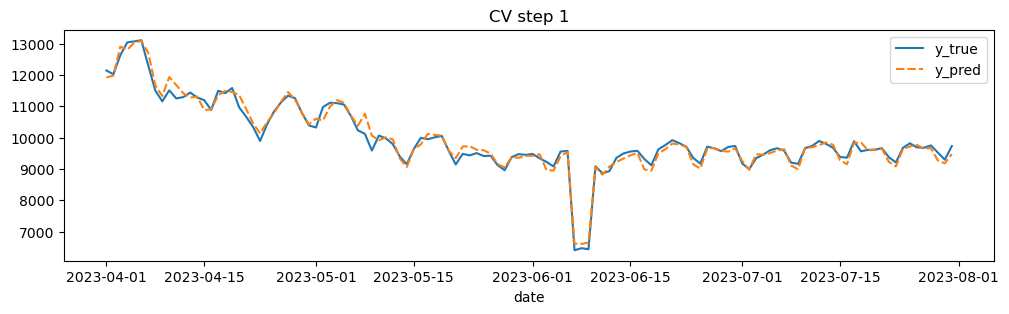

LGBM fold 1 MAE: 130.42112395209872
LGBM fold 1 MAPE: 0.013129451878706098
LGBM fold 1 r2: 0.9750575496099646
Fold 2:
End of train: 2021-11-29
Valid: from 2021-11-29 to 2022-03-31
Test: from 2023-04-01 to 2023-07-31
[100]	valid_0's l2: 203.783
[200]	valid_0's l2: 193.421
[300]	valid_0's l2: 188.222
[400]	valid_0's l2: 184.354
[500]	valid_0's l2: 183.468
[600]	valid_0's l2: 183.344
[700]	valid_0's l2: 182.704
[800]	valid_0's l2: 183.019
[900]	valid_0's l2: 182.947


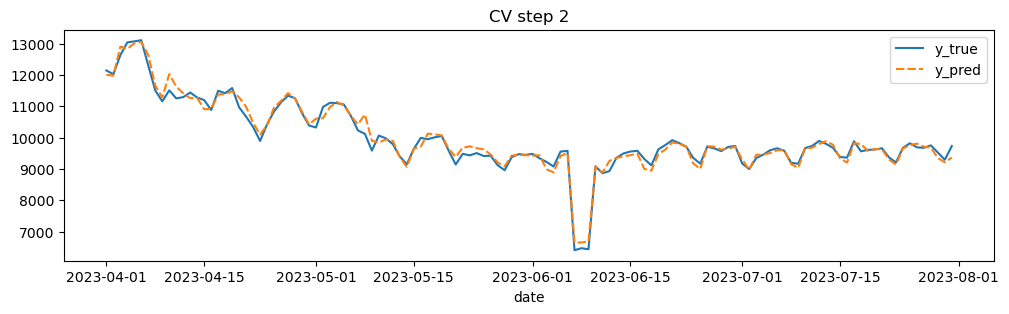

LGBM fold 2 MAE: 124.25033366856245
LGBM fold 2 MAPE: 0.012584303748778477
LGBM fold 2 r2: 0.976790997277654
Fold 3:
End of train: 2022-03-31
Valid: from 2022-03-31 to 2022-07-30
Test: from 2023-04-01 to 2023-07-31
[100]	valid_0's l2: 133.022
[200]	valid_0's l2: 128.343
[300]	valid_0's l2: 125.746
[400]	valid_0's l2: 124.468
[500]	valid_0's l2: 126.588
[600]	valid_0's l2: 127.107


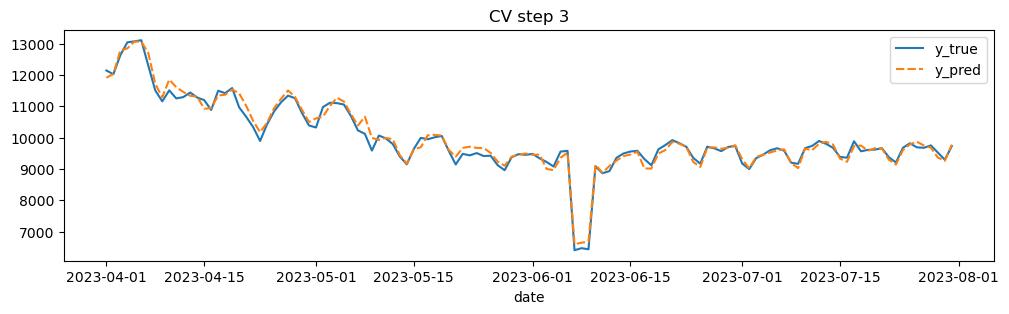

LGBM fold 3 MAE: 123.06910293314426
LGBM fold 3 MAPE: 0.012390870094576982
LGBM fold 3 r2: 0.9782556771116682
Fold 4:
End of train: 2022-07-30
Valid: from 2022-07-30 to 2022-11-30
Test: from 2023-04-01 to 2023-07-31
[100]	valid_0's l2: 87.7112
[200]	valid_0's l2: 86.8364
[300]	valid_0's l2: 87.9094
[400]	valid_0's l2: 87.6688


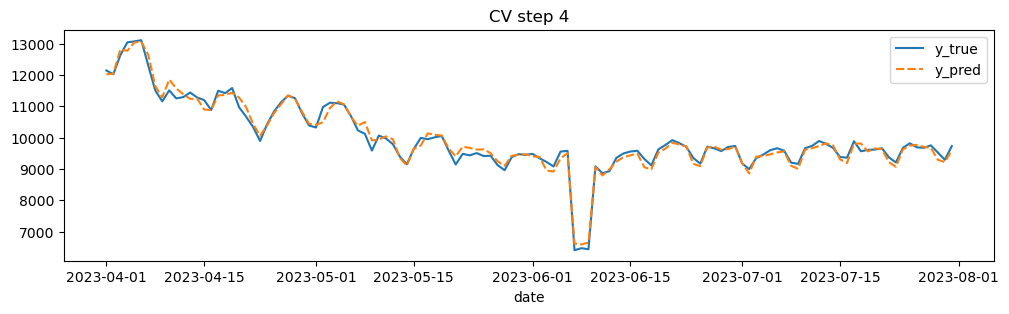

LGBM fold 4 MAE: 118.20057363069002
LGBM fold 4 MAPE: 0.011957336828041646
LGBM fold 4 r2: 0.9809790228783504
Fold 5:
End of train: 2022-11-30
Valid: from 2022-12-01 to 2023-03-31
Test: from 2023-04-01 to 2023-07-31
[100]	valid_0's l2: 187.022
[200]	valid_0's l2: 176.112
[300]	valid_0's l2: 177.706
[400]	valid_0's l2: 175.913


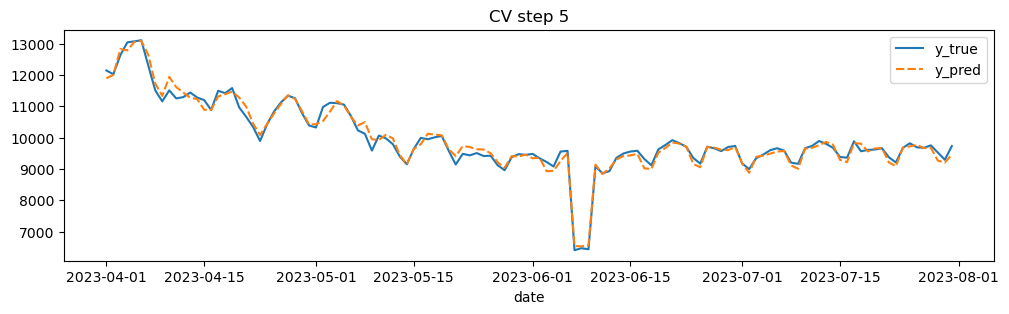

LGBM fold 5 MAE: 120.33932001485039
LGBM fold 5 MAPE: 0.01201361888171774
LGBM fold 5 r2: 0.9790549730686716


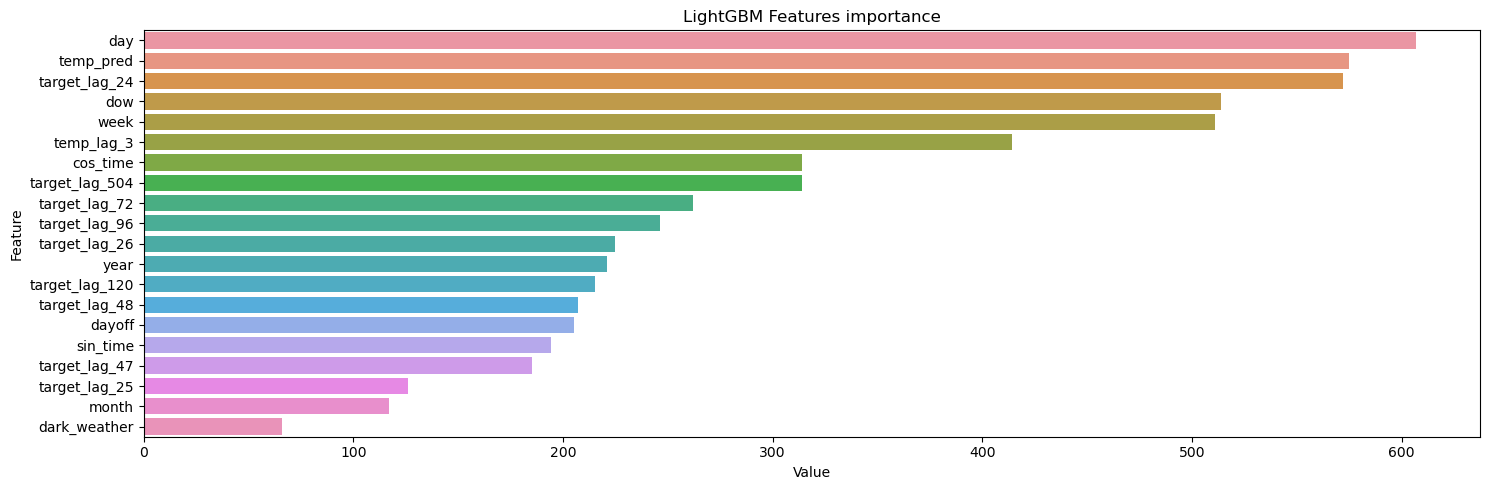

In [ ]:
lgbm_maes, lgbm_mapes, lgbm_r2, lgbm_forecast, lgbm_model = lgbm_cross_val(df=df, cols_to_drop=['date', 'target'])

Посмотрим на средние метрики по итогам кросс-валидации

In [ ]:
metrics = {'MAE': lgbm_maes, 'MAPE': lgbm_mapes, 'r2': lgbm_r2}
for metric in metrics:
    print(f"LGBM mean {metric}: {np.mean(metrics[metric])}")

LGBM mean MAE: 123.25609083986917
LGBM mean MAPE: 0.01241511628636419
LGBM mean r2: 0.9780276439892617


Сохраним модель для дальнейшего использования

In [ ]:
# save the model to pickle file
model_pkl = "model.pkl"

with open(model_pkl, 'wb') as file:
    pickle.dump(lgbm_model, file)

Убедимся, что качество модели, загруженной из файла, не отличается

In [ ]:
# load model from pickle file
with open(model_pkl, 'rb') as file:
    lgbm_reg_loaded = pickle.load(file)

In [ ]:
test = df[(df['date'] >= start_test) & (df['date'] <= end_test)]
test_dates = test['date']

X_test = test.drop(['date', 'target'], axis=1)
y_test = test['target']

preds = lgbm_reg_loaded.predict(X_test)
preds = pd.DataFrame({'y_pred': preds, 'date': test_dates, 'y_true': y_test})
forecast_result = preds.groupby('date')[['y_pred', 'y_true']].sum()

lgbm_mae = mean_absolute_error(forecast_result['y_true'], forecast_result['y_pred'])
lgbm_mape = mean_absolute_percentage_error(forecast_result['y_true'], forecast_result['y_pred'])
lgbm_r2 = r2_score(forecast_result['y_true'], forecast_result['y_pred'])

#print metrics
metrics = {'MAE': lgbm_mae, 'MAPE': lgbm_mape, 'r2': lgbm_r2}
for metric in metrics:
    print(f"Loaded model {metric}: {metrics[metric]}")

Loaded model MAE: 120.33932001485039
Loaded model MAPE: 0.01201361888171774
Loaded model r2: 0.9790549730686716


Все верно, результат совпадает с последним фолдом кросс-валидации, где модель обучалась на наиболее полной обучающей выборке